# Finetuning de modelos de clasificación LULC.


## 1. Librerías y activación de GPU en Google Colab

**Nota:** este Notebook requiere una cuenta de usuario en Google Colab y Google Earth Engine.

In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [ ]:
#Montar drive de Google
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
path='drive/myDrive/Colab Notebooks/'

### Google Colab GPU


In [10]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


## 2. EuroSAT Dataset
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For simplicity, we will focus on RGB image classification.

In [ ]:

!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip


### 2.1 Generar sets Train y Test.

#### `Dataset` Classes de Pytorch.


In [ ]:
class CustomImageDataset(data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [2]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations 
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

#### Data Augmentation

Data augmentation is a  technique that randomly applies image transformations, e.g. crops, horizontal flips, and vertical flips, to the input images during model training. These perturbations reduce the neural network's overfitting to the training dataset, and they allow it to generalize better to the unseen test dataset.

#### Normalización de Imágenes


ImageNet is a large training dataset of images and labels.  Later in this tutorial, we will be using a model pre-trained on this dataset.  In order to use this pre-trained model for our LULC dataset, we need to ensure that the input dataset is normalized to have the same statistics (mean and standard deviation) as ImageNet.

Existing research has found that using models pretrained on massive datasets, such as ImageNet, improves accuracy when applying these neural networks to new datasets.  Pre-trained models serve as excellent generic feature extractors.  [Please read here for more information](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [3]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

#### Load EuroSAT Dataset

In [5]:
# Load the dataset
data_dir='EuroSAT/2750'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


#### Split into Train and Test Sets
The training set will be 80% of the Eurosat dataset, randomly selected. The remaining 20% of the dataset will be our test set.

In [6]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 80% train / 20% test
# by subsetting the transformed train and test datasets
train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


Usamos `torch`'s `DataLoader` para crear un dataloader. 

In [7]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

#### Visualizar el Dataset.


In [ ]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
   
    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

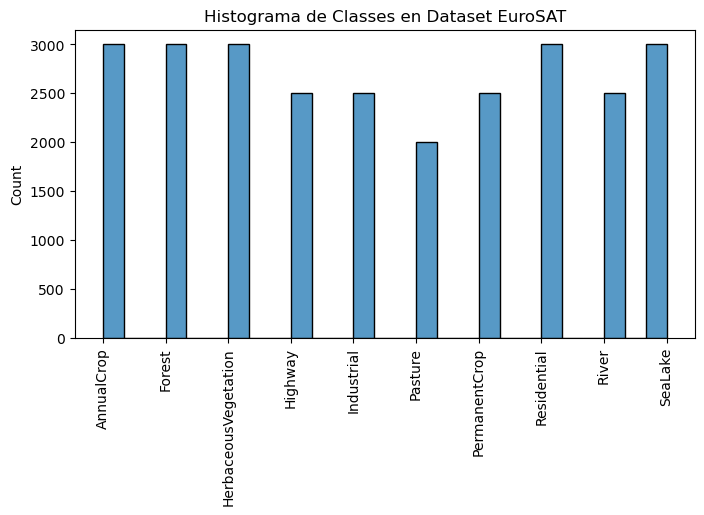

In [8]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histograma de Classes en Dataset EuroSAT')

plt.show()

In [ ]:
len(dataset.targets)

## 2.2 Desarrollo del Modelo

## Instancia del Modelo

We will use a standard neural network architecture, called ResNet50. Based on [the work by Helber et al.](https://arxiv.org/pdf/1709.00029.pdf), ResNet-50 has been shown to work well for LULC classification on the EuroSAT

### ResNet-50
<b>Recall</b>: Deep neural networks are difficult to train due to the problem of vanishing or exploding gradients (repeated multiplication making the gradient infinitively small). ResNet solves this by using shortcut connections that connect activation from an earlier layer to a further layer by skipping one or more layers as shown below. This allows for gradients to propagate to the deeper layers before they can be reduced to small or zero values.
<br><br>

<center> <img src="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png" width="600"/><br>
Image source: <a href="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/">https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/  </a>
</center>
<br>
Note that when we load the model, we set the `pre-trained` flag to be True to indicate that the loaded model should be already pre-trained on the Imagenet dataset.

In [11]:
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

In the next cell, we'll define our criterion and optimizer.

### Cross Entropy Loss
We define our loss as the cross-entropy loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. ([Source](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

For two classes, it is computed as:

$−ylog(p)-(1−y)log(1−p)$

For multiclass classification with $M$ classes, it is defined as:

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

where

- $M$ - number of classes (dog, cat, fish)
- $log$ - the natural log
- $y_{o,c}$ - binary indicator (0 or 1) if class label $c$ is the classification for observation $o$
- $p_{o,c}$- predicted probability observation $o$ is of class $c$

### Stochastic Gradient Descent
Remember that the goal of stochastic gradient descent (SGD) is to minimize the loss function. To do this, it computes the slope (gradient) of the loss function at the current point and moves in the opposite direction of the slope towards the steepest descent.
<center> <img src="https://miro.medium.com/max/1400/1*P7z2BKhd0R-9uyn9ThDasA.png" width="350"/><br>Image source:
<a href="https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a">https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a</a>
</center>
<br>

In [12]:
n_epochs = 5
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#### Crear train function

In [13]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

Next, let's define the model evaluation function.

In [14]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

#### Entrenamiento

In [ ]:
# Keep track of the best loss and
# best model weights with the lowest loss
best_loss = np.inf
best_model = None

# Train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, train_loader, criterion, optimizer)
  test_loss, _ = evaluate(model, test_loader, criterion)

  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

Epoch 1


  0%|          | 0/1350 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/paguirre/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/paguirre/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'EuroSAT' on <module '__main__' (built-in)>


#### Guardar el modelo


In [ ]:
model_dir = "models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

modelName='EuroSAT_model.pth'
model_file = model_dir + modelName
torch.save(best_model, model_file)
print('Model successfully saved to {}'.format(model_file))

#### Cargar el modelo


In [ ]:

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load(model_file))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

### 2.3 Resultados

Veamos un ejemplo de predicción.

In [ ]:
# Retrieve sample image
index = 5
image, label = test_data[index]

# Predict on sample
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

In [ ]:
_, pred = torch.max(output, 1)

pred,pred[0],class_names[pred[0]],class_names

Here, we show how to run the model on a PIL image.

In [ ]:
from PIL import Image
image_path = 'PetorcaSAT/jilin/built/0-6.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Congrats on making it this far! Go to the next section, [Part 2: Automating Land Use and Land Cover Mapping using Python.](https://colab.research.google.com/drive/13I1wZT7thBlNdGA1tFQrK1MlRhMZMnpM?usp=sharing).